<a href="https://colab.research.google.com/github/kevinhhl/portfolio-management-tools/blob/main/Monte_Carlo_Simulation_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import date
import time
from pandas.tseries.offsets import BDay
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Overview:
This script will obtain historical price data from Yahoo and then perform a Monte Carlo Simulation by doing a random walk to forecast the reasonable ranges of prices.


**Parameters**

In [2]:
ticker                                              = "TSLA"
hist_yyyy, hist_mm, hist_dd                         = 2018, 1, 1                 # start date, historical lookback
t0_yyyy, t0_mm, t0_dd                               = 2023, 2, 18                # [t0] end date for historical lookback, and start date for simulations
tn_yyyy, tn_mm, tn_dd                               = 2023, 6, 30                # [tn] end date for simulations (no. of periods to be determined based on no. of business days in between t0 and tn)


Number of iterations should be at least 500, and 800, in order for forecasted mean and standard deviation values (respectively) to converge. [1]



In [3]:
n_iters                                             = 5000                       # No. of iterations for random walk. 
assert n_iters > 800

# Processing source data:

In [4]:
# Alternative to importing yfinance as yf!
def get_csv_link(date_from, date_to):
  _date_from = time.mktime(date_from.timetuple())
  _date_to = time.mktime(date_to.timetuple())
  s1 = "https://query1.finance.yahoo.com/v7/finance/download/"
  _s2 = str(int(_date_from))
  _s3 = str(int(_date_to))
  s4 = "?period1="+ _s2 +"&period2="+ _s3 +"&interval=1d&events=history&includeAdjustedClose=true"
  return s1 + ticker + s4
csv = pd.read_csv(get_csv_link(date(hist_yyyy, hist_mm, hist_dd), date(t0_yyyy, t0_mm, t0_dd)))
csv

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
1,2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2,2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
3,2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
4,2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000
...,...,...,...,...,...,...,...
1287,2023-02-13,194.419998,196.300003,187.610001,194.639999,194.639999,172475500
1288,2023-02-14,191.940002,209.820007,189.440002,209.250000,209.250000,216455700
1289,2023-02-15,211.759995,214.660004,206.110001,214.240005,214.240005,182108600
1290,2023-02-16,210.779999,217.649994,201.839996,202.039993,202.039993,229586500


**Historical Returns**

*   pc = historical log returns, based on Adjusted Close
*   drift = mean minus half-variance of historical log returns



In [5]:
import numpy as np

adj_close = csv["Adj Close"]
pc = np.log(1+adj_close.pct_change()) 

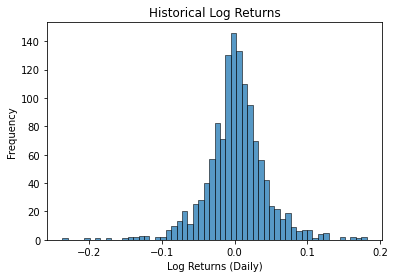

In [6]:
sb.histplot(pc.iloc[1:])
plt.title("Historical Log Returns")
plt.xlabel("Log Returns (Daily)")
plt.ylabel("Frequency");

In [7]:
mean = pc.mean()
var = pc.var()
stddev = pc.std()
drift = mean - 0.5*var
print("mean={}, var={}, drift={}".format(mean, var, drift))


mean=0.0017638277367745822, var=0.0017215249742246707, drift=0.0009030652496622469


# Performing Random Walk

In [8]:
date_t0 = date(t0_yyyy, t0_mm, t0_dd)
date_tn = date(tn_yyyy, tn_mm, tn_dd)

n_forecast = 0        # Counter++ for each business days existing in between t0 and tn
_t0 = date_t0         # tmp var.
while _t0 <= date_tn:
  n_forecast += 1
  _t0 += BDay(1)

<ipython-input-8-9f2d752b4e12>:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while _t0 <= date_tn:



TSLA
Shape=(96, 5000)
Simulation: From 2023-02-18 to 2023-06-30; Business days=94


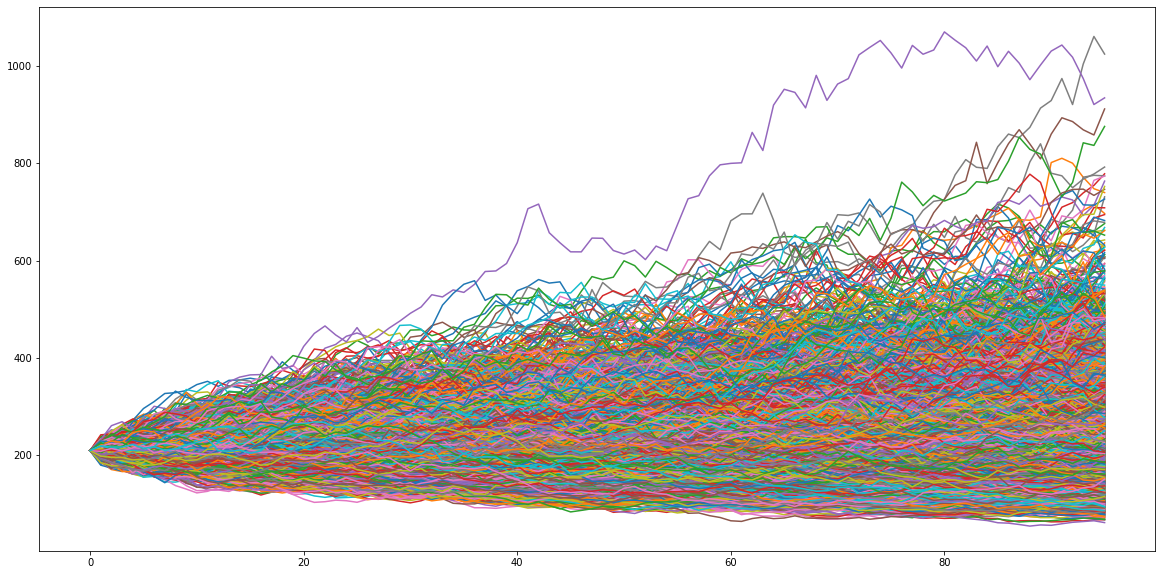

In [9]:
# Init. array[n_forecast][n_iters] of zeros 
rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))
sim_equity_curve = np.zeros_like(rand_returns)

# Assume single asset porfolio. Value of portfolio on day 1 of forecast is the Adj. Close price on that date. 
sim_equity_curve[0] = adj_close[len(adj_close)-1]

# Perform random walk and plot
for t in range(1,n_forecast):
    sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]

assert(sim_equity_curve.shape==rand_returns.shape)
print("\n{}\nShape={}".format(ticker, sim_equity_curve.shape))
print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn))) 

plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(sim_equity_curve).iloc[:,0:]);

In [10]:
count = 0
stdev_multi = 2
print("{}\nt+n; \t\t\t\tstd \t\tmean \t\tmean - {}*std \t\tmean + {}*std \n"\
      .format(ticker, stdev_multi,stdev_multi))
for e in sim_equity_curve:
  std = e.std()
  mean = e.mean()
  print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}"\
        .format(count, date_t0+BDay(count), std.round(2), mean.round(2), (mean-stdev_multi*std).round(2), (mean+stdev_multi*std).round(2)))
  count += 1


TSLA
t+n; 				std 		mean 		mean - 2*std 		mean + 2*std 

t+0 	2023-02-20 00:00:00 	std = 0.0 	mean = 208.31 	lower = 208.31 		upper = 208.31
t+1 	2023-02-20 00:00:00 	std = 8.6 	mean = 208.81 	lower = 191.62 		upper = 226.0
t+2 	2023-02-21 00:00:00 	std = 12.23 	mean = 209.24 	lower = 184.77 		upper = 233.7
t+3 	2023-02-22 00:00:00 	std = 14.76 	mean = 209.4 	lower = 179.89 		upper = 238.92
t+4 	2023-02-23 00:00:00 	std = 17.02 	mean = 209.7 	lower = 175.67 		upper = 243.73
t+5 	2023-02-24 00:00:00 	std = 19.09 	mean = 209.92 	lower = 171.73 		upper = 248.11
t+6 	2023-02-27 00:00:00 	std = 21.05 	mean = 210.48 	lower = 168.37 		upper = 252.59
t+7 	2023-02-28 00:00:00 	std = 22.71 	mean = 210.89 	lower = 165.46 		upper = 256.32
t+8 	2023-03-01 00:00:00 	std = 24.3 	mean = 211.05 	lower = 162.45 		upper = 259.66
t+9 	2023-03-02 00:00:00 	std = 25.91 	mean = 211.25 	lower = 159.42 		upper = 263.07
t+10 	2023-03-03 00:00:00 	std = 27.33 	mean = 211.64 	lower = 156.97 		upper = 266.31
t+11 

---
**References:**

[1] E. Bukaçi, Th. Korini, E. Periku, S. Allkja and P. Sheperi (2016). Number of iterations needed in Monte Carlo Simulation using reliability analysis for tunnel supports. [online] https://www.ijera.com. Available at: https://www.ijera.com/papers/Vol6_issue6/Part%20-%203/J0606036064.pdf.